In [1]:
#!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# Connecting to google API
- https://developers.google.com/sheets/api/quickstart/python#configure_the_sample

In [3]:
# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.json', 'w') as token:
        token.write(creds.to_json())

## Read cell values

https://developers.google.com/sheets/api/guides/values#read_a_single_range

In [4]:
def get_values(spreadsheet_id, range_name, creds):
    """
    Creates the batch_update the user has access to.
    Load pre-authorized user credentials from the environment.
    TODO(developer) - See https://developers.google.com/identity
    for guides on implementing OAuth2 for the application.
        """
    #creds, _ = google.auth.default()
    # pylint: disable=maybe-no-member
    try:
        service = build('sheets', 'v4', credentials=creds)

        result = service.spreadsheets().values().get(
            spreadsheetId=spreadsheet_id, range=range_name).execute()     
        return result
    except HttpError as error:
        print(f"An error occurred: {error}")
        return error    

In [5]:
# set the range in the sheet. Is always the same for all sheets
range_name = 'Summary!B28:E40'

# create the empty datafrems
sheet_expenses = pd.DataFrame(columns=['Month','Category','Planned','Actual'])

# open the file with the sheets per month
with open('sheets.csv','r') as file:
    
    # itereate through each line
    for line in file:
        
        # set the month
        month = line.split(';')[0].strip()
        
        # set the spreadsheet id
        spreadsheet_id = line.split(';')[1].strip()
        
        print(f'Month: {month}, ID: {spreadsheet_id}')
        
        # get the values of the sheet
        data = get_values(spreadsheet_id, range_name, creds)
        
        # create a temporary dataframe for the month        
        temp_df = pd.DataFrame(data=data['values'],columns=['Category','blank','Planned','Actual'])
        
        # convert the columns Planned and Actual to float
        temp_df['Planned'] = temp_df['Planned'].str.replace('\$','',regex=True).replace('\,','',regex=True).astype('float')
        temp_df['Actual'] = temp_df['Actual'].str.replace('\$','',regex=True).replace('\,','',regex=True).astype('float')
        
        # add the month
        temp_df['Month'] = month
        
        # concatenate the final df with the temp df
        sheet_expenses = pd.concat([sheet_expenses,temp_df],ignore_index=True)
        
        # delete the temp df
        del temp_df

# drop blank column
sheet_expenses = sheet_expenses.drop('blank',axis=1)

Month: Sep, ID: 1AOEBxLKpistd_LyzPUJ8iEdhdp5v7Pl9dY-B7bKvAjc
Month: Oct, ID: 1A8eOgUSCDoUGj2u0ZTAFFuph6D_zE-D3-xACEGyLnT4
Month: Nov, ID: 1BPPRQu6jMeTQimlHPiZB3UdExgitkozm1upBdG6tliM
Month: Dec, ID: 104LlF2f0NAXs4d0TXIm_DGaUhrlpYGm7cuyG7TEvgFc
Month: Jan, ID: 1EZf46PnIek5rapAnoSpGGv8hiBBwawvVV76_t7H2Lh4
Month: Feb, ID: 1kX6XC7zkeL9wBwlnLOZuQluVJLhWzN6VXUxba1dAPOE
Month: Mar, ID: 1KH73tCRQR22Kb0F8UC6bFISB95bzR4eVmk8NfRy6BGE
Month: Apr, ID: 11phv3gNeKb-Hr75fEKbRlKcoeieDJdWGiJAv410IG1E


To ensure the privacy and security of my personal data, I have chosen not to disclose the precise values of my expenses in this project. Instead, I will introduce a deliberate amount of noise to the data as a means to obfuscate the actual values. By doing so, I aim to maintain the confidentiality of sensitive information while still enabling meaningful analysis. I believe this approach aligns with valid and understandable reasons for protecting personal data.

In [6]:
# Replace the rent for March
sheet_expenses.loc[(sheet_expenses['Month'] == 'Mar') & (sheet_expenses['Category'] == 'Rent'), ['Planned', 'Actual']] = sheet_expenses[sheet_expenses['Category']=='Rent']['Planned'].max()

# Replace the rent for April
sheet_expenses.loc[(sheet_expenses['Month'] == 'Apr') & (sheet_expenses['Category'] == 'Rent'), ['Planned', 'Actual']] = sheet_expenses[sheet_expenses['Category']=='Rent']['Planned'].max()


In [8]:
# check for null values
sheet_expenses.isnull().sum()

Month       0
Category    0
Planned     0
Actual      0
dtype: int64

In [9]:
# check for na values
sheet_expenses.isna().sum()

Month       0
Category    0
Planned     0
Actual      0
dtype: int64

## EDA

Within our expenses, there are several one-time costs that occur sporadically, such as payments for college tuition and books. In addition, there are occasional expenses, like the 'Furniture' category, which only appears in two months. While these categories still represents a significant one-time expense when it occurs, it is infrequent and will be excluded from the analysis.

The 'Personal' and 'Other' categories group together expenses that are related to purchasing personal items, such as clothing, shoes, and personal care and hygiene products. These expenses may include things like toiletries, makeup, hair care products, and other personal care items. The 'Personal' category might also include items like hair cuts or electronics, whereas the 'Other' category could include things like books or music instruments. Although these categories are similar in nature, they are separated to provide more clarity when analyzing and categorizing expenses.

In [11]:
# categories to delete
cat_to_del = ['Custom category 1','Custom category 2','Health/medical','Debt','College','Furniture']

# delete the categories
sheet_expenses = sheet_expenses[~sheet_expenses['Category'].isin(cat_to_del)]

In [12]:
# Pivot the dataframe
monthly_expenses = sheet_expenses.melt(id_vars=['Month','Category'],value_vars=['Planned','Actual'],
                                       value_name='Amount',var_name='Type')

### Grouping Catagories

- Cellphone and Internet

In [13]:
# Group Cellphone and Internet in the same category
phone_internet = ['Cellphone','Internet']

In [14]:
# create a data frame for phone_internet
phone_internet_df = monthly_expenses[monthly_expenses['Category'].isin(phone_internet)].groupby(['Month','Type']).sum()

# add the category 'Phone and Internet'
phone_internet_df['Category'] = 'Phone and Internet'

# reset the index
phone_internet_df = phone_internet_df.reset_index()

# concat the dataframes
monthly_expenses = pd.concat([monthly_expenses,phone_internet_df], axis=0, ignore_index=True)

# delete the rows for phone_internet
monthly_expenses = monthly_expenses[~monthly_expenses['Category'].isin(phone_internet)]

- Food

In [15]:
# Group Food and Dinning Out in the same category
food = ['Food','Dinning Out']

In [16]:
# create a data frame for phone_internet
food_df = monthly_expenses[monthly_expenses['Category'].isin(food)].groupby(['Month','Type']).sum()

# add the category 'Phone and Internet'
food_df['Category'] = 'Food'

# reset the index
food_df = food_df.reset_index()

# delete the rows for food
monthly_expenses = monthly_expenses[~monthly_expenses['Category'].isin(food)]

# concat the dataframes
monthly_expenses = pd.concat([monthly_expenses,food_df], axis=0, ignore_index=True)

- Personal and Other

In [17]:
# Group Personal and Other in the same category
personal = ['Personal','Other']

In [18]:
# create a data frame for phone_internet
personal_df = monthly_expenses[monthly_expenses['Category'].isin(personal)].groupby(['Month','Type']).sum()

# add the category 'Phone and Internet'
personal_df['Category'] = 'Personal and Misc.'

# reset the index
personal_df = personal_df.reset_index()

# concat the dataframes
monthly_expenses = pd.concat([monthly_expenses,personal_df], axis=0, ignore_index=True)

# delete the rows for food
monthly_expenses = monthly_expenses[~monthly_expenses['Category'].isin(personal)]

- Renaming Categories

In [19]:
# rename TTC to Transportation
monthly_expenses['Category'] = monthly_expenses['Category'].replace('TTC','Transportation')

# rename Netflix-Spotify to Streaming
monthly_expenses['Category'] = monthly_expenses['Category'].replace('Netflix-Spotify','Streaming')

# rename Other to hBBO.
monthly_expenses['Category'] = monthly_expenses['Category'].replace('Other','Misc')

In [20]:
# export the dataframe for Tableau
monthly_expenses.to_csv('montly_expenses.csv',index=False)

## Visualizing the data

In [21]:
# Get the mean of expenses by category
mean_expenses = monthly_expenses.groupby('Category')[['Amount']].mean()

# Reset the index
mean_expenses = mean_expenses.reset_index()

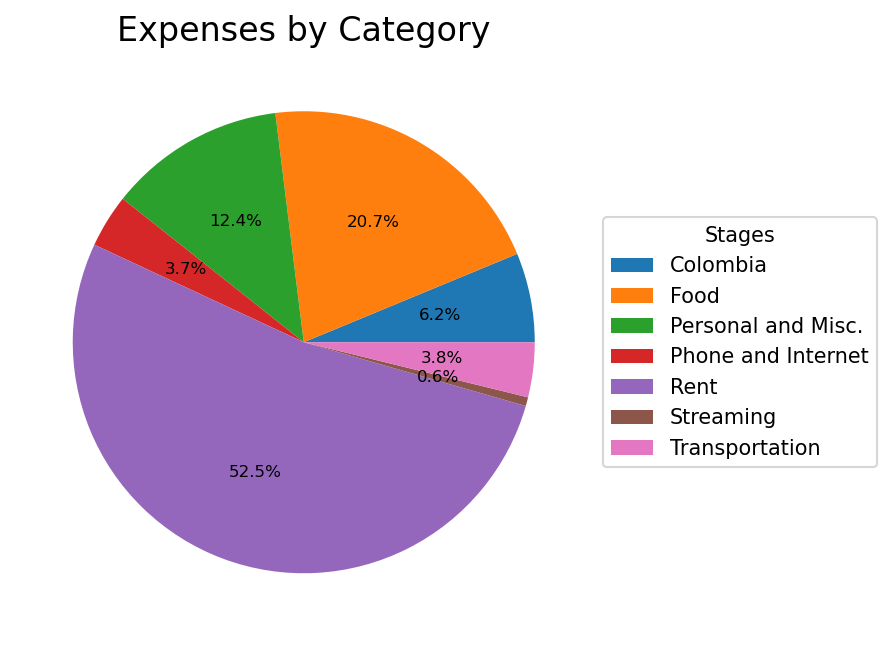

In [23]:
# Plot the expenses by Category
plt.figure(figsize=(5,5), dpi=150)
plt.pie(mean_expenses['Amount'],autopct='%1.1f%%',textprops={'fontsize': 8})
plt.legend(labels=mean_expenses['Category'],title="Stages", loc="center left", bbox_to_anchor=(1, 0, .0, 1))
plt.title('Expenses by Category',fontsize=16)
plt.show();


In [24]:
# Get the sum of expenses by category and Type
cat_expenses = monthly_expenses.groupby(['Category','Type'])[['Amount']].sum()

# reset the index
cat_expenses = cat_expenses.reset_index()

In [25]:
# Calculate the difference between 'Actual' and 'Planned' amounts for each category
category_diff = cat_expenses.pivot(index='Category', columns='Type', values='Amount')
category_diff['Difference'] = category_diff['Actual'] - category_diff['Planned']

# Sort the categories based on the difference in amounts
category_diff = category_diff.sort_values('Difference', ascending=False)

# export the dataframe
category_diff.to_csv('category_diff.csv', index=True)

In [26]:
category_diff

Type,Actual,Planned,Difference
Category,,,
Personal and Misc.,5698.4,2181.6,3516.8
Colombia,1779.2,1704.0,75.2
Phone and Internet,1208.8,1165.6,43.2
Rent,16720.0,16720.0,0.0
Streaming,187.2,204.0,-16.8
Transportation,1016.0,1427.2,-411.2
Food,5839.2,7360.0,-1520.8


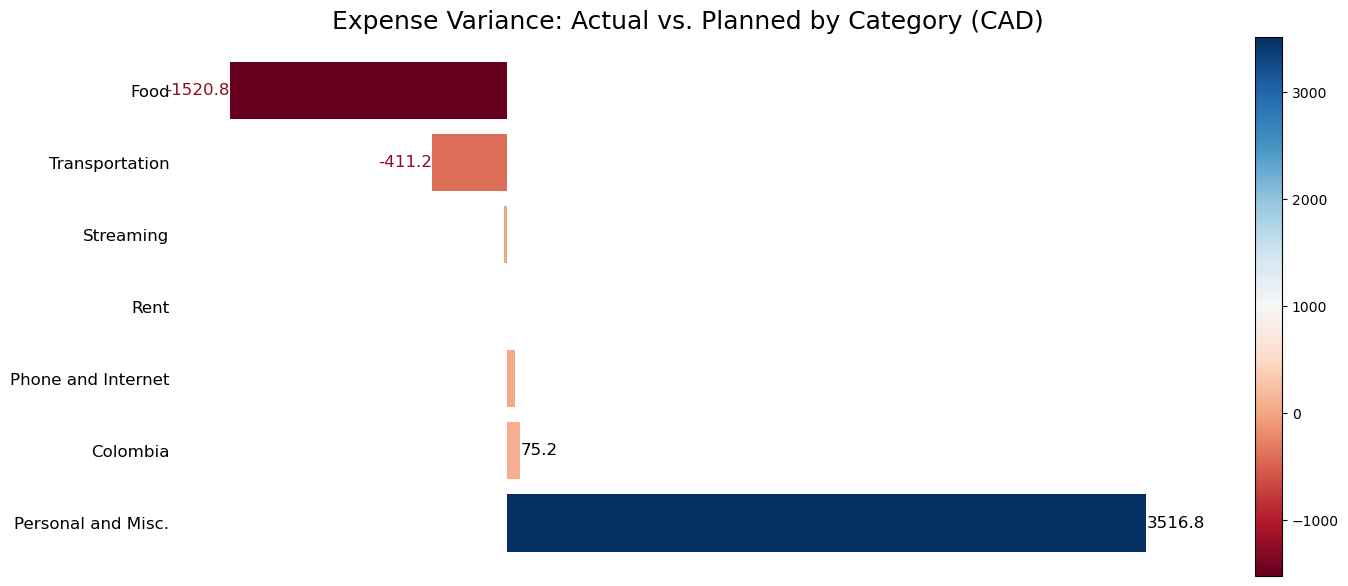

In [27]:
# Create the horizontal bar plot with gradient color
fig, ax = plt.subplots(figsize=(9, 7),dpi=100)  # Adjust the figure size if needed

# Define the colormap for the gradient color
cmap = cm.get_cmap('RdBu')

# Normalize the difference values for mapping to the colormap
norm = plt.Normalize(vmin=category_diff['Difference'].min(), vmax=category_diff['Difference'].max())

# Plot the bars with gradient color
bars = ax.barh(category_diff.index, category_diff['Difference'], color=cmap(norm(category_diff['Difference'])), 
               height=0.8, edgecolor='none', linewidth=0)

# Add text labels to the bars
for bar in bars:
    width = bar.get_width()
    if width > 50:
        ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.1f}', ha='left', va='center', fontsize=12)
    elif width < -50:
        ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.1f}', ha='right', va='center', fontsize=12, 
                color='#8d0c25')

# Remove axes labels and ticks
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=True, labelright=False, labelbottom=False,
              labelsize=12)

# Remove the spines (borders) of the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines["left"].set_position(("data", -1800))

# Add a colorbar to show the mapping of values to colors
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')

# Add a title to the graph
plt.title('Expense Variance: Actual vs. Planned by Category (CAD)', fontsize=18)

# Adjust the layout to add more space on the left
plt.subplots_adjust(left=-.5)

plt.show()


In [28]:
# Pivot the dataframe
expenses_df = monthly_expenses.pivot_table(index=['Month','Type'],columns='Category', values='Amount', aggfunc=sum)

# reset the index
expenses_df = expenses_df.reset_index()

# reset the axis name
expenses_df = expenses_df.rename_axis('', axis='columns')

# filling na values
expenses_df = expenses_df.fillna(0)

In [29]:
# select the numeric columns
num_cols = expenses_df.select_dtypes(include=['float64','int64'])

# add the total column
expenses_df['Total'] = expenses_df[num_cols.columns].sum(axis=1)

In [31]:
grouped = expenses_df.groupby(['Month','Type'])
# Calculate the difference between 'Actual' and 'Planned' expenses
difference = grouped['Total'].sum().unstack().diff(axis=1)

# reset the index
difference = difference.reset_index()

# create a df
result_df = pd.DataFrame({
    'Month':difference['Month'],
    'Difference':difference['Planned']
})

# order the result_df by month
result_df = result_df.sort_values(by='Month', key=lambda x: pd.to_datetime(x, format='%b'))

result_df.to_csv('difference_by_month.csv', index=False)

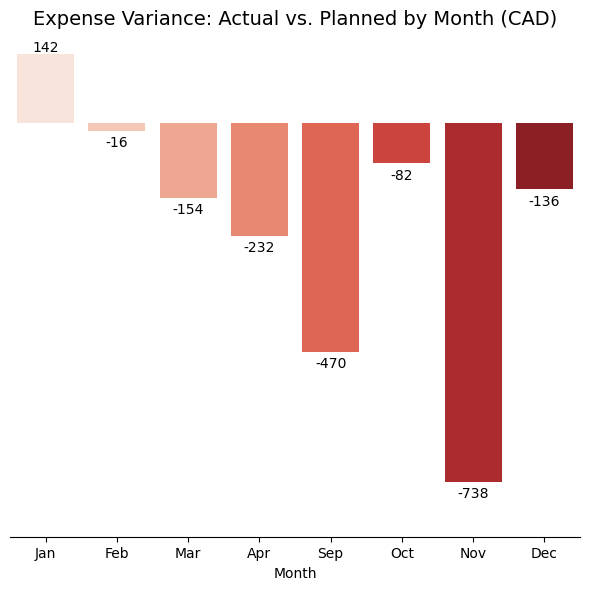

In [32]:
fig, ax = plt.subplots(figsize=(6,6),dpi=100)

# set the title
plt.title('Expense Variance: Actual vs. Planned by Month (CAD)', fontsize=14)

# Define the colormap for the gradient color
cmap = cm.get_cmap('Reds').reversed()

# Plot the bar chart with the inverted colormap
ax = sns.barplot(data=result_df, x='Month', y='Difference', palette='Reds')

# Add text labels to the bars
for i, value in enumerate(result_df['Difference']):
    if value<0:
        ax.annotate(str(round(value)), (i, value-10), ha='center', va='top')
    else:
        ax.annotate(str(round(value)), (i, value), ha='center', va='bottom')        

# hide spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_position(("data", -850))

# hide ticks
ax.tick_params(axis='y', left=False,labelleft=False)

# Axes Label
ax.set_ylabel('')

# Adjust a save the image
plt.tight_layout()
# Display the plot
plt.show()

In [33]:
# Pivot the dataframe
expenses_df = monthly_expenses.pivot_table(index=['Month','Type'],columns='Category', values='Amount', aggfunc=sum)

# reset the index
expenses_df = expenses_df.reset_index()

# reset the axis name
expenses_df = expenses_df.rename_axis('', axis='columns')

# filling na values
expenses_df = expenses_df.fillna(0)

In [34]:
# select the numeric columns
num_cols = expenses_df.select_dtypes(include=['float64','int64'])

# add the total column
expenses_df['Total'] = expenses_df[num_cols.columns].sum(axis=1)

In [39]:
expenses_df = expenses_df.rename_axis('', axis='columns')

In [40]:
num_cols = expenses_df.select_dtypes(include=['float64','int64'])
num_cols = num_cols.drop('Total', axis=1)

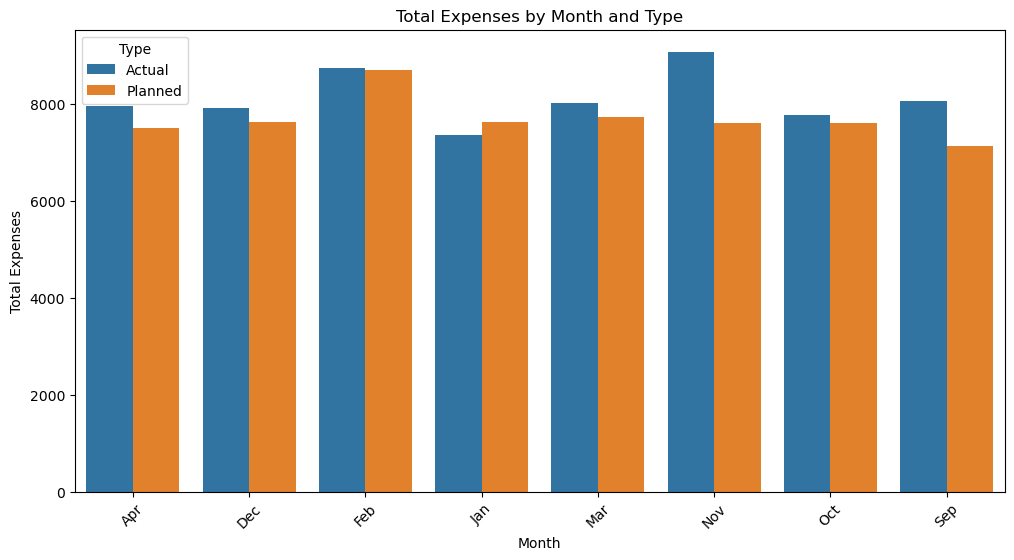

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total expenses by month and expense type
expenses_by_month_type = expenses_df.groupby(['Month', 'Type']).sum().reset_index()

# Plot the total expenses by month and expense type
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Total', hue='Type', data=expenses_by_month_type)
plt.title('Total Expenses by Month and Type')
plt.xlabel('Month')
plt.ylabel('Total Expenses')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.show()
